# TP2 - AI : Heuristic Research and Constraint Satisfaction Problems
---
_Author: CHRISTOFOROU Anthony_\
_Due Date: 25-10-2023_\
_Updated: 18-10-2023_\
_Description: TP2 - AI_

---

In [1]:
# Libraries
import matplotlib
from IPython.display import HTML
from typing import List, Tuple

# Modules
from assignment2.datastructures.node import Node
from assignment2.datastructures.variable import Variable
from assignment2.datastructures.constraint import HouseConstraint
from assignment2.datastructures.csp import CSP

from assignment2.algorithms.greedy_search import GreedyBestFirstSearch
from assignment2.algorithms.backtracking import BacktrackingSolver

from assignment2.visualisations.visualise import SearchPathVisualizer

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. A* Algorithm

![graph](./img/graph.png)

### 1.1. Blind Search

The directed graph shown in *Figure 1* represents the state space of a certain problem, with the transition costs denoted by the numbers on the edges. The initial state, $S_I$​, is denoted by "S" and the goal state, $S_G$, is denoted by "G". We aim to traverse this graph to reach the goal state from the initial state using a blind search algorithm. Specifically, we will employ the Breadth-First Search (BFS) algorithm.

**Breadth-First Search (BFS) Development:**

Given the provided directed graph, we can use BFS starting from node **S** to reach node **G**.

<div class="alert alert-info">
We are going to search by alphabetical order, so <b>A</b> is visited before <b>F</b>.
</div>

**Development Table:**

| Node | Parent | Cost |
|------|--------|------|
| S    | -      | -    |
| A    | S      | 2    |
| F    | S      | 7    |
| C    | A      | 6    |
| H    | F      | 9    |
| G    | F      | 12   |
| D    | C      | 9    |

**Search Tree:**

```
      S
     / \
    A   F
   /   / \
  C   G   H
 /       
D 
```


### 1.2 Heuristic Search

The following table shows the heuristic $h(n)$ estimating the cost of the path until the goal state for each node $n$ in the graph.

| State | S | A | C | D | F | G | H |
|-----------|-------|-------|-------|-------|-------|-------|-------|
| **h(n)**  | 10    | 5     | 4     | 3     | 4     | 0     | 2     |

1. Let's show that this heuristic function is admissible and why:

**Definition**: A heuristic function $h(n)$ is said to be admissible if, for every node $n$ of the graph, $h(n)$ never overestimates the true cost to reach the goal node from $n$.

Given the heuristic values in the table above, to determine if $h$ is admissible, we would have to ensure that for each state, the heuristic value is less than or equal to the actual cost from that state to the goal state G.

This means that formally if we define the actual cost from state $n$ to the goal state $G$ as $c(n, G)$, then we would have to ensure that for each state $n$:

$$h(n) \leq c(n, G)$$

let's check this for each state using the cheapest path from each state to the goal state:

- $h(S) = 10 \leq c(S, G) = 11$ : **True**
- $h(A) = 5 \leq c(A, G) = 9$ : **True**
- $h(C) = 4 \leq c(C, G) = 5$ : **True**
- $h(D) = 3 \leq c(D, G) = 3$ : **True**
- $h(F) = 4 \leq c(F, G) = 5$ : **True**
- $h(G) = 0 \leq c(G, G) = 0$ : **True**
- $h(H) = 2 \leq c(H, G) = \varnothing$ : **True** (A cost of 2 is better than an impossible cost)

2. Now, let's show that this heuristic function is consistent and why:

**Definition**: A heuristic function $h(n)$ is said to be consistent (or monotone) if, for every node $n$ of the graph and for every successor $n'$ of $n$ with step cost $c(n, n')$, we have that:

$$h(n) \leq c(n, n') + h(n')$$

Given the heuristic values in the table above, to determine if $h$ is consistent, we would have to ensure that for each state, the heuristic value is less than or equal to the actual cost from that state to the goal state G.

To prove that $h$ is not consistent, we need to find a state $n$ and one of its successors $n'$ such that $h(n) > c(n, n') + h(n')$. In our case we can take $n = S$ and $n' = A$:

$$h(S) = 10 > c(S, A) + h(A) = 2 + 5 = 7$$ 

This does not satisfy the consistency condition, **so $h$ is not consistent**.

3. What are the evaluation functions used by the greedy best first search and the A* algorithm?

- **Greedy Best First Search**: $f(n) = h(n)$

> This method selects the node based on the heuristic value alone. It aims to expand the node that is closest to the goal, as estimated by the heuristic function.

- **A\* Algorithm**: $f(n) = g(n) + h(n)$

> Where:
> 
> - $g(n)$ is the cost of the path from the start node to $n$
> - $h(n)$ is the estimated cost from $n$ to the goal node (heuristic function)
> 
> The A* algorithm considers both the cost to reach the current node and the estimated cost from the current node to the goal.

4. Let's implement the **Greedy Best First Search**

In [2]:
# defining the graph and the functions

GRAPH = {
    'S': [('F'), ('A')],
    'F': [('H'), ('G'), ('A')],
    'A': [('C'), ('F')],
    'C': [('D'), ('G')],
    'D': [('G')],
    'G': [],
    'H': []
}
HEURISTIC = {
    'S': 10,
    'A': 5,
    'C': 4,
    'D': 3,
    'F': 4,
    'G': 0,
    'H': 2
}
ALL_EDGES = [
    ('S', 'F'), 
    ('S', 'A'), 
    ('F', 'H'), 
    ('F', 'G'), 
    ('F', 'A'), 
    ('A', 'C'), 
    ('A', 'F'), 
    ('C', 'D'), 
    ('C', 'G'), 
    ('D', 'G')
]

def successors(state: str) -> List[Tuple[str, float]]:
    return GRAPH.get(state, [])

def heuristic(state: str) -> float:
    return HEURISTIC.get(state, float('inf'))  # Return a large value for states not in the heuristic


In [3]:
# Define start node and goal state
start_node = Node("S")
goal_state = "G"

# search algorithm
gbfs = GreedyBestFirstSearch(successors=successors, heuristic=heuristic) # Initialise the search algorithm
path = gbfs.execute(start_node, goal_state, logging=True) # Execute the search

if path is None:
    print("No path found")
else:
    print("Path found:", path)

Path found: [S, F, G]


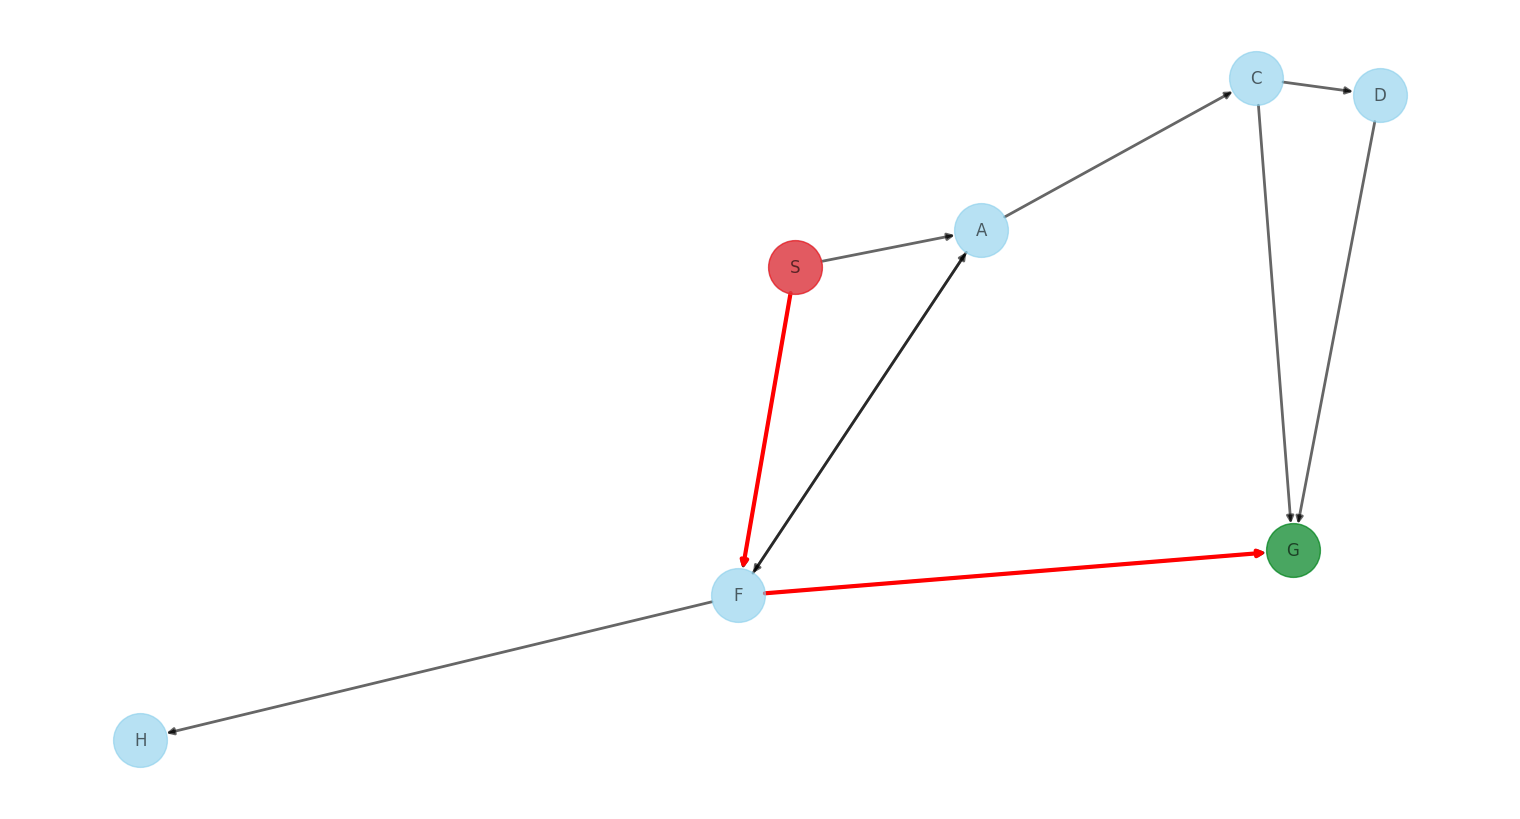

In [4]:
spv = SearchPathVisualizer(ALL_EDGES) # Initialise the search path visualiser
spv.plot_search_path(path) # Visualise the search path

5. How could we modify this algorithm to make it into the A* algorithm?

- Instead of using the heuristic function $h(n)$, we use the evaluation function $f(n) = g(n) + h(n)$
- When exploring a node, we add the cost of the path from the start node to the current node as $g(n)$

6. Let's build the search trees for both algorithms and compare them. We will first make a table of the nodes expanded by each algorithm with the order of expansion and the evaluation function value at each node and its parent.

#### **Greedy Best First Search**

| Node | Value | Parent |
|------|-------|--------|
| S    | 10    | -      |
| A    | 5     | S      |
| F    | 4     | S      |
| G    | 0     | F      |
| H    | 2     | F      |

**Search Tree:**

```
      S
     / \
    A   F
       / \
      G   H
```

Here the value of the evaluation function is $f(n) = h(n)$, so we expand the node with the lowest heuristic value.

#### **A\* Algorithm**

| Node | Value | Parent |
|------|-------|--------|
| S    | 10    | -      |
| A    | 7     | S      |
| F    | 11    | S      |
| C    | 10    | A      |
| D    | 12    | C      |
| G    | 11    | C      |

**Search Tree:**

```
      S
     / \
    A   F
   /  
  C  
 / \
D   G
```

Here the value of the evaluation function is $f(n) = g(n) + h(n)$, so we get:

- $f(S) = g(S) + h(S) = 0 + 10 = 10$
- $f(A) = g(A) + h(A) = 2 + 5 = 7$
- $f(F) = g(F) + h(F) = 7 + 4 = 11$
- $\ldots$

<div class="alert alert-info">
Again, we are doing a search by alphabetical order, so <b>A</b> is visited before <b>F</b>, that way we don't have to put all the nodes in the table.
</div>

## 2 Constraint Satisfaction Problems

An architect needs to build a house with 4 rooms (1,2,3,4) organized as follows:

![House Organization](./img/house.png)

- The left side of the house consists of rooms 1 and 2, while the right side consists of rooms 3 and 4.
- Two rooms are adjacent if they share a complete wall (for example, room 2 is adjacent to rooms 1 and 3 but not to room 4).

You must decide where to place the basement $C$ (one of the four rooms), a window $F$, and an exterior door $P$. The future homeowners of the house have given the following constraints:

- $F$ cannot be in room $C$, nor in one of the rooms adjacent to $C$.
- $C$ and $P$ cannot be on the same side (left or right) of the house.
- The room containing $F$ must be adjacent to at least two rooms.
- The room containing $P$ must also be adjacent to at least two rooms.

### 2.1 Problem Formulation in the form of a CSP

Let's define the variables, domains and constraints of the problem:

1. **Variables:**

The variables in this problem, in the context of a Constraint Satisfaction Problem (CSP), represent the decisions that need to be made, namely:

- $C$: The basement
- $F$: The window
- $P$: The exterior door

Thus, we can define the set of variables as:

$$x_i, \quad \forall i \in \{C, F, P\}$$

This representation isn't unique, we could have chosen to represent the variables as the rooms in the house, but this would have made the constraints more complicated.
We choose this representation as it as the least number of variables.

2. **Domains:**

The domains of the variables represent the possible values that each variable can take. In this case, the domains are the rooms in the house, so we can define the set of domains as:

$$D_i = \{1, 2, 3, 4\}, \quad \forall i \in \{C, F, P\}$$

3. **Constraints:**

We saw in the previous section that the future homeowners of the house have given the 4 following constraints:

1. $ F $ cannot be in $ C $, nor in one of the rooms adjacent to $ C $.
2. $ C $ and $ P $ cannot be on the same side of the house.
3. The room containing $ F $ must be adjacent to at least two rooms.
4. The room containing $ P $ must also be adjacent to at least two rooms.

**Representation of constraints:**

1. For the first constraint:  (**Binary Constraint**)
   - If $ x_C = 1 $, then $ x_P $ cannot be 1 or 2.
   - If $ x_C = 2 $, then $ x_P $ cannot be 1, 2, or 3.
   - If $ x_C = 3 $, then $ x_P $ cannot be 2, 3, or 4.
   - If $ x_C = 4 $, then $ x_P $ cannot be 3 or 4.

   $ c_1 = < x_C, x_F >: <1, 3>, <1, 4>, <2, 4>, <3, 1>, <4, 1>, <4, 2> $

2. For the second constraint: (**Binary Constraint**) \
   $ C $ and $ P $ can't be on the same side. Thus:\
   $ c_2 = < x_C, x_P >: <1, 3>, <1, 4>, <2, 3>, <2, 4>, <3, 1>, <3, 2>, <4, 1>, <4, 2> $

3. For the third constraint: (**Unary Constraint**) \
   $ F $ must be adjacent to at least two rooms. This means $ x_2 $ can be 2 or 3 only.\
   $ c_3 = < x_F >: <2>, <3> $

4. For the fourth constraint: (**Unary Constraint**) \
   $ P $ must also be adjacent to at least two rooms. This means $ x_3 $ can be 2 or 3 only.\
   $ c_4 = < x_P >: <2>, <3> $

### 2.2 Backtracking Search

Let's implement the backtracking search algorithm to solve this problem.

Using the constraints $c_3$ and $c_4$, we can reduce the domains of $F$ and $P$ to:

- $D_F = \{2, 3\}$
- $D_P = \{2, 3\}$

<div class="alert alert-info">
We are going to assign the variables in alphabetical order, so <b>C</b> is assigned before <b>F</b> and <b>P</b>.
</div>

In [5]:
# Create variables
C = Variable(name='C', domain=[1, 2, 3, 4])
F = Variable(name='F', domain=[2, 3])
P = Variable(name='P', domain=[2, 3])

# Create constraints
house_constraint = HouseConstraint([C, F, P])

# Create CSP problem
csp = CSP(variables=[C, F, P], constraints=[house_constraint])


solver = BacktrackingSolver(csp)
solution = solver.solve()

print(f"Solutions found: {solution}")

Solutions found: [{'C': 1, 'F': 3, 'P': 3}, {'C': 4, 'F': 2, 'P': 2}]


### AC3 Algorithm

Let's use the AC-3 (Arc-Consistency 3) algorithm to reduce the domain of the variables using the unary constraints and then propagate those constraints.

**Initial Domains** (based on the problem):
$$ D(x_C) = D(x_F) = D(x_P) = \{1, 2, 3, 4\} $$

**Applying Unary Constraints**:
1. $ c_3 $: $ x_F $ can be 2 or 3.
$$ D(x_F) = \{2, 3\} $$

1. $ c_4 $: $ x_P $ can be 2 or 3.
$$ D(x_P) = \{2, 3\} $$

**Applying AC-3 Algorithm**:
- We enqueue all the arcs in the queue.
- For each arc $ (x_i, x_j) $, we check for consistency. If a value in the domain of $ x_i $ has no consistent value in the domain of $ x_j $, we remove that value from $ D(x_i) $ and enqueue all arcs $ (x_k, x_i) $ where $ k \neq j $.

Starting with the binary constraints:

1. $ c_1 $:
- For $ x_C = 1 $, $ x_F $ cannot be 1 or 2. Since the domain of $ x_F $ is already \{2, 3\}, no reduction occurs.
- Similarly, for the other values of $ x_C $, the domain of $ x_F $ remains consistent.

2. $ c_2 $:
- For $ x_C = 1 $ or $ x_C = 2 $, $ x_P $ can be 3 or 4. However, since the domain of $ x_P $ is already \{2, 3\}, it gets reduced to just \{3\}.
- For $ x_C = 3 $ or $ x_C = 4 $, $ x_P $ can be 1 or 2. But the domain of $ x_P $ remains consistent with \{3\}.

After the propagation using AC-3:
$$ D(x_C) = \{1, 2, 3, 4\} $$
$$ D(x_F) = \{2, 3\} $$
$$ D(x_P) = \{3\} $$

Thus, after the application of AC-3:
- The domain of $ x_C $ remains unchanged.
- The domain of $ x_F $ is reduced to \{2, 3\} due to the unary constraint.
- The domain of $ x_P $ is further reduced to \{3\} after propagation.